In [84]:
# tools
import numpy as np
import pandas as pd
import re
import tldextract
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
# plot
import seaborn as sns
import matplotlib.pyplot as plt
# export model
import joblib
# import skl2onnx
# from skl2onnx.common.data_types import FloatTensorType
import shutil
import subprocess
import os

In [70]:
df1 = pd.read_csv('../resource/phishing_site_urls.csv')
df2 = pd.read_csv('../resource/out.csv')
df3 = pd.read_csv('../resource/custom_made.csv')

In [71]:
df2 = df2.rename(columns={'url': 'URL', 'label': 'Label'})
df2 = df2[['URL', 'Label']]
df = pd.concat([df1, df2, df3], axis=0)
df['Label'] = df['Label'].astype(str)
df['URL'] = df['URL'].astype(str)
df

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
...,...,...
5,github.com,good
6,instagram.com,good
7,youtube.com,good
8,reddit.com,good


In [72]:
# helper methods
def extract_subdir_TLD(url):
    splitted = re.split(r'(?<!/)/(?!/)', url)
    return 1 if any('.' in part for part in splitted[1:]) else 0

def count_www_outside_domain(url):
    splitted = re.split(r'(?<!/)/(?!/)', url)
    return sum(1 for part in splitted[1:] if 'www' in part)

def count_subdomain(url):
    extracted = tldextract.extract(url)
    return 0 if len(extracted.subdomain) == 0 else extracted.subdomain.count('.') + 1

def digit_letter_ratio(url):
    splitted = list(url)
    splitted = list(map(lambda x: 0 if str(x).isalpha() else 1, splitted))
    return 0 if splitted.count(0) == 0 else splitted.count(1) / splitted.count(0)

def non_alnum_ratio(url):
    splitted = list(url)
    splitted = list(map(lambda x: 0 if str(x).isalnum() else 1, splitted))
    return sum(splitted) / len(splitted)


In [73]:
# extract features
df = df.copy()
df = df.drop_duplicates(subset=['URL'])
df['Label'] = df['Label'].replace({'bad': 0, 'phishing': 0, 'good': 1, 'legitimate': 1}).infer_objects(copy=False)
df['Length'] = df['URL'].map(len)
df['Dot_count'] = df['URL'].str.count(r'\.')
df['At_count'] = df['URL'].str.count(r'\@')
df['Perc_count'] = df['URL'].str.count(r'%')
df['Dash_count'] = df['URL'].str.count(r'_')
df['Subdirectory_contains_TLD'] = df['URL'].map(extract_subdir_TLD)
df['Digit_letter_ratio'] = df['URL'].map(digit_letter_ratio)
df['Num_of_subdomain'] = df['URL'].map(count_subdomain)
df['Num_of_www_outside_domain'] = df['URL'].map(count_www_outside_domain)
df['Non_alnum_ratio'] = df['URL'].map(non_alnum_ratio)
df

C:\Users\LAPTOP\AppData\Local\Temp\ipykernel_18044\2873078433.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Label'] = df['Label'].replace({'bad': 0, 'phishing': 0, 'good': 1, 'legitimate': 1}).infer_objects(copy=False)


,URL,Label,Length,Dot_count,At_count,Perc_count,Dash_count,Subdirectory_contains_TLD,Digit_letter_ratio,Num_of_subdomain,Num_of_www_outside_domain,Non_alnum_ratio
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,0,225,6,0,0,4,1,0.666667,0,0,0.142222
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,0,81,5,0,0,1,1,0.246154,1,0,0.185185
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,0,177,7,0,0,0,1,0.594595,0,0,0.107345
3,mail.printakid.com/www.online.americanexpress....,0,60,6,0,0,0,1,0.153846,1,1,0.133333
4,thewhiskeydregs.com/wp-content/themes/widescre...,0,116,1,0,0,0,0,0.414634,0,0,0.112069
...,...,...,...,...,...,...,...,...,...,...,...,...
2,chatgpt.com,1,11,1,0,0,0,0,0.100000,0,0,0.090909
5,github.com,1,10,1,0,0,0,0,0.111111,0,0,0.100000
6,instagram.com,1,13,1,0,0,0,0,0.083333,0,0,0.076923
7,youtube.com,1,11,1,0,0,0,0,0.100000,0,0,0.090909


In [74]:
# label ratio
print((df['Label']==0).sum()/len(df['Label']))

0.4536777782359381


In [75]:
# correlation between label and features
absolute_corr = df.drop(columns=['URL']).corr().map(abs)
absolute_corr['Label'].sort_values(ascending=False)

Label                        1.000000
Non_alnum_ratio              0.440274
Subdirectory_contains_TLD    0.356871
Length                       0.325444
Digit_letter_ratio           0.274110
Dot_count                    0.242967
Num_of_subdomain             0.089236
Num_of_www_outside_domain    0.088171
At_count                     0.083343
Dash_count                   0.050312
Perc_count                   0.020257
Name: Label, dtype: float64

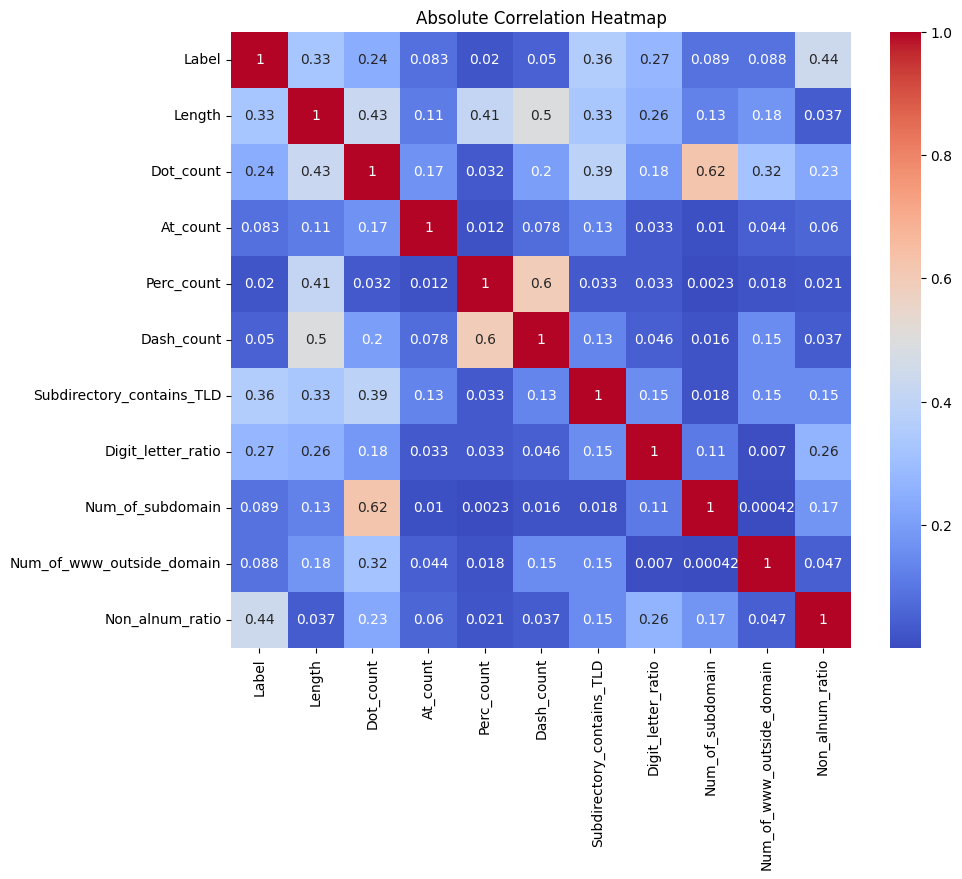

In [76]:
# absolute correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(absolute_corr, annot=True, cmap='coolwarm')
plt.title('Absolute Correlation Heatmap')
plt.show()

In [77]:
# prepare data
X = df.drop(columns=['Label', 'URL'])
y = df['Label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [78]:
# random forest classifier
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_val)

In [79]:
# accuracy, precision and recall score
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy Score: {accuracy}')
precision = precision_score(y_val, y_pred)
print(f'Precision Score: {precision}')
recall = recall_score(y_val, y_pred)
print(f'Recall Score: {recall}')

Accuracy Score: 0.9294925512104283
Precision Score: 0.9472416066902718
Recall Score: 0.922331869676748


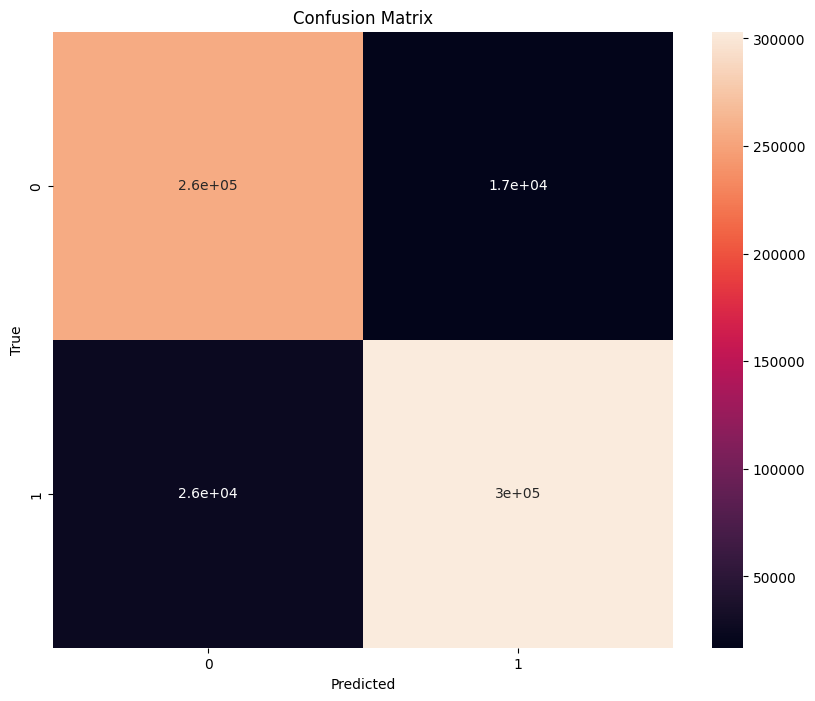

In [80]:
#confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [85]:
joblib.dump(rf_classifier, 'model.pkl')

['model.pkl']

In [82]:
# export
# initial_type = [('float_input', FloatTensorType([None, X_train.shape[1]]))]
# onnx_model = skl2onnx.convert_sklearn(rf_classifier, initial_types=initial_type, options={'zipmap': False})
# with open('model.onnx', 'wb') as f:
#     f.write(onnx_model.SerializeToString())

In [88]:
#move model
source_file = 'model.pkl'
destination_directory = '../phishing-detector'
shutil.copy(source_file, destination_directory)
subprocess.run(['icacls', os.path.join(destination_directory, 'model.pkl'), '/grant', 'Everyone:(R)'], check=True)

CompletedProcess(args=['icacls', '../phishing-detector\\model.pkl', '/grant', 'Everyone:(R)'], returncode=0)